# Introduction

As the name suggests, random forest models basically contain an ensemble of decision tree models, with each decision tree predicting the same response variable. The response may be categorical, in which case being a classification problem, or continuous / numerical, being a regression problem.

In this short tutorial, we will go through the use of tree-based methods (decision tree, bagging model, and random forest) for both classification and regression problems. Each section of this tutorial corresponds to an individual R script that can be found in the GitHub repo at https://github.com/tohweizhong/RUGS-RF.git. This tutorial serves to complement the code walkthrough session in our workshop. For more details on these models, please refer to the slides. Alternatively, you can email me at [tohweizhong@u.nus.edu](mailto:tohweizhong@u.nus.edu) or [tohweizhong@hotmail.com](mailto:tohweizhong@hotmail.com) if you have any questions.

This tutorial is divided into two sections. We will first use tree-based methods for classification on the spam dataset from the kernlab package - the same dataset used in the previous RUGS workshop on support vector machines (SVM). Subsequently, we will apply these methods on a regression problem, with the imports85 dataset from the randomForest package.

# Tree-based methods for classification

## Preparation
Let’s start by loading the spam dataset and doing some preparations:

In [1]:
# packages that we will need:
#  @ kernlab:      for the spam dataset
#  @ tree:         for decision tree construction
#  @ randomForest: for bagging and RF
#  @ beepr:        for a little beep
#  @ pROC:         for plotting of ROC

# code snippet to install and load multiple packages at once
#pkgs <- c("kernlab","tree","randomForest","beepr","pROC")
#sapply(pkgs,FUN=function(p){
#        print(p)
#        if(!require(p)) install.packages(p)
#        require(p)
#})

# load required packages
suppressWarnings(library(kernlab))
suppressWarnings(library(tree))
suppressWarnings(library(randomForest))
suppressWarnings(library(beepr)) # try it! beep()
suppressWarnings(library(pROC))

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



In [2]:
# load dataset
data(spam)

# take a look
str(spam)

'data.frame':	4601 obs. of  58 variables:
 $ make             : num  0 0.21 0.06 0 0 0 0 0 0.15 0.06 ...
 $ address          : num  0.64 0.28 0 0 0 0 0 0 0 0.12 ...
 $ all              : num  0.64 0.5 0.71 0 0 0 0 0 0.46 0.77 ...
 $ num3d            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ our              : num  0.32 0.14 1.23 0.63 0.63 1.85 1.92 1.88 0.61 0.19 ...
 $ over             : num  0 0.28 0.19 0 0 0 0 0 0 0.32 ...
 $ remove           : num  0 0.21 0.19 0.31 0.31 0 0 0 0.3 0.38 ...
 $ internet         : num  0 0.07 0.12 0.63 0.63 1.85 0 1.88 0 0 ...
 $ order            : num  0 0 0.64 0.31 0.31 0 0 0 0.92 0.06 ...
 $ mail             : num  0 0.94 0.25 0.63 0.63 0 0.64 0 0.76 0 ...
 $ receive          : num  0 0.21 0.38 0.31 0.31 0 0.96 0 0.76 0 ...
 $ will             : num  0.64 0.79 0.45 0.31 0.31 0 1.28 0 0.92 0.64 ...
 $ people           : num  0 0.65 0.12 0.31 0.31 0 0 0 0 0.25 ...
 $ report           : num  0 0.21 0 0 0 0 0 0 0 0 ...
 $ addresses        : num  0 0.14 1.75 0 0

In this example, we will attempt to predict whether an email is spam or nonspam. To do so, we will construct models on one subset of the data (training data), and use the constructed model on another disparate subset of the data (the testing data). This is known as cross validation.

In [4]:
# preparation for cross validation:
# split the dataset into 2 halves,
# 2300 samples for training and 2301 for testing
num.samples <- nrow(spam) # 4,601
num.train   <- round(num.samples/2) # 2,300
num.test    <- num.samples - num.train # 2,301
num.var     <- ncol(spam) # 58

# set up the indices
set.seed(150715)
idx       <- sample(1:num.samples)
train.idx <- idx[seq(num.train)]
test.idx  <- setdiff(idx,train.idx)

# subset the data
spam.train <- spam[train.idx,]
spam.test  <- spam[test.idx,]

Taking a quick glance at the type variable:

In [5]:
table(spam.train$type)


nonspam    spam 
   1397     903 

In [6]:
table(spam.test$type)


nonspam    spam 
   1391     910 

## Decision tree
Now that we are done with the preparation, let’s start by constructing a decision tree model, using the tree package:

In [7]:
tree.mod <- tree(type ~ ., data = spam.train)

Here’s how our model looks like:

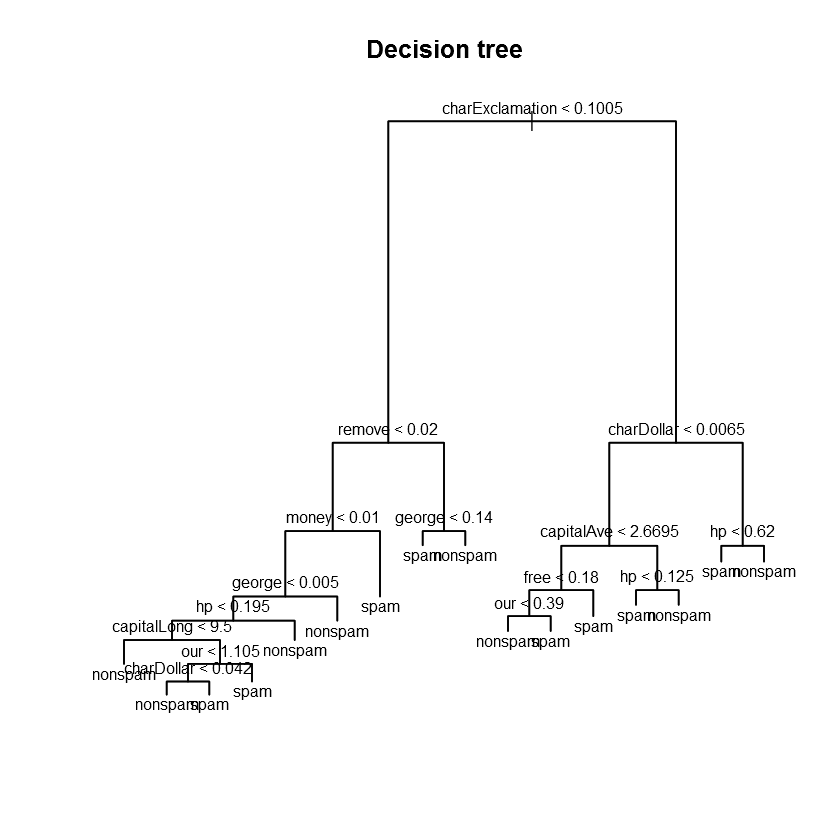

In [8]:
plot(tree.mod)
title("Decision tree")
text(tree.mod, cex = 0.75)

The model may be overtly complicated. Typically, after constructing a decision tree model, we may want to prune the model, by collapsing certain edges, nodes and leaves together without much loss of performance. This is done by iteratively comparing the number of leaf nodes with the model’s performance (by k-fold cross validation within the training set).

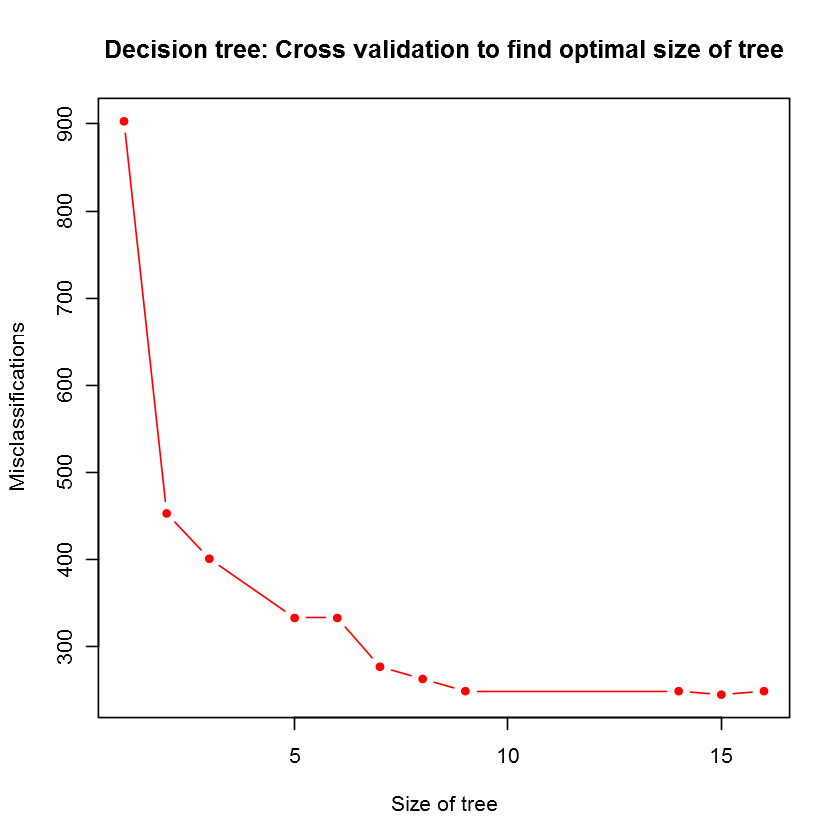

In [9]:
cv.prune <- cv.tree(tree.mod, FUN = prune.misclass)
plot(cv.prune$size, cv.prune$dev, pch = 20, col = "red", type = "b",
     main = "Decision tree: Cross validation to find optimal size of tree",
     xlab = "Size of tree", ylab = "Misclassifications")

Having 9 leaf nodes may be good (maximising performance while minimising complexity).

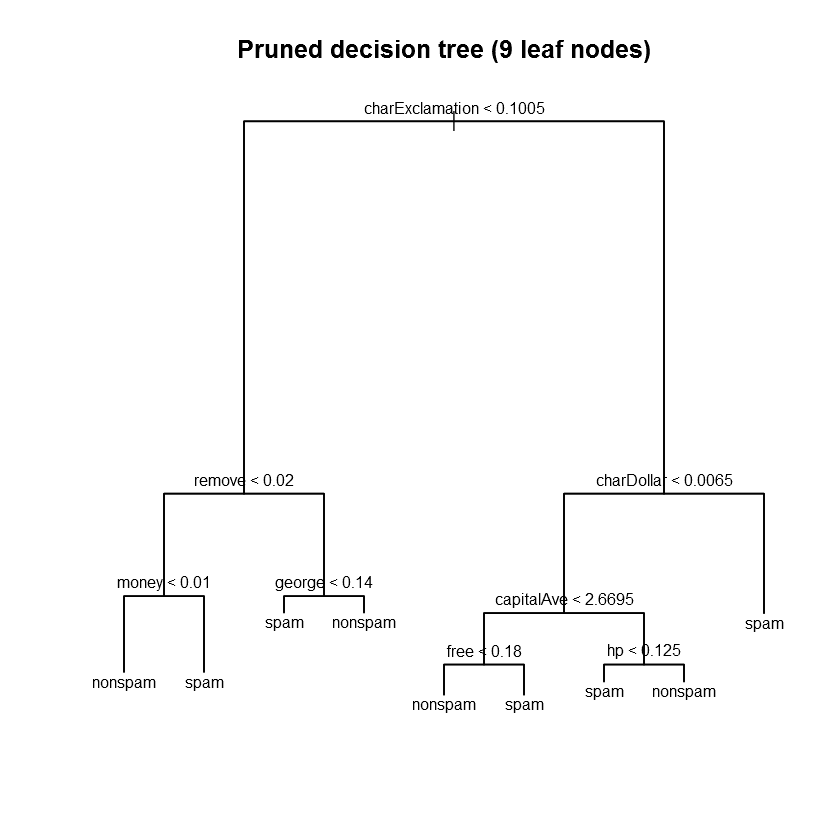

In [10]:
best.tree.size <- 9

# pruning (cost-complexity pruning)
pruned.tree.mod <- prune.misclass(tree.mod, best = best.tree.size)

# here's the new tree model
plot(pruned.tree.mod)
title(paste("Pruned decision tree (", best.tree.size, " leaf nodes)",sep = ""))
text(pruned.tree.mod, cex = 0.75)

Now with our new model, let’s make some predictions on the testing data.

In [11]:
tree.pred <- predict(pruned.tree.mod,
                     subset(spam.test, select = -type), 
                     type = "class")

# confusion matrix
# rows are the predicted classes
# columns are the actual classes
print(tree.pred.results <- table(tree.pred, spam.test$type))

         
tree.pred nonspam spam
  nonspam    1308  164
  spam         83  746


In [12]:
# What is the accuracy of our tree model?
print(tree.accuracy <- (tree.pred.results[1,1] + tree.pred.results[2,2]) / sum(tree.pred.results))

[1] 0.8926554


Our decision tree model is able to predict spam vs. nonspam emails with about 89.27% accuracy. We will make comparisons of accuracies with other models later.

## Bagging
Next, we turn our attention to the bagging model. Recall that bagging, a.k.a. bootstrap aggregating, is the process of sampling (with replacement), samples from the training data. Each of these subsets are known as bags, and we construct individual decision tree models using each of these bags. Finally, to make a classification prediction, we use the majority vote from the ensemble of decision tree models.

In [13]:
bg.mod<-randomForest(type ~ ., data = spam.train,
                     mtry = num.var - 1, # try all variables at each split, except the response variable
                     ntree = 300,
                     proximity = TRUE,
                     importance = TRUE)

In the bagging, and also the random forest model, there are often only two hyperparameters that we are interested in: mtry, which is the number of variables to try from for each tree and at each split, and ntree, the number of trees in the ensemble. Tuning the number of trees is relatively easy by looking at the out-of-bag (OOB) error estimate of the ensemble at each step of the way. For more details, refer to the slides. We set proximity = TRUE and importance = TRUE, in order to get some form of visualization of the model, and the variable importances respectively.

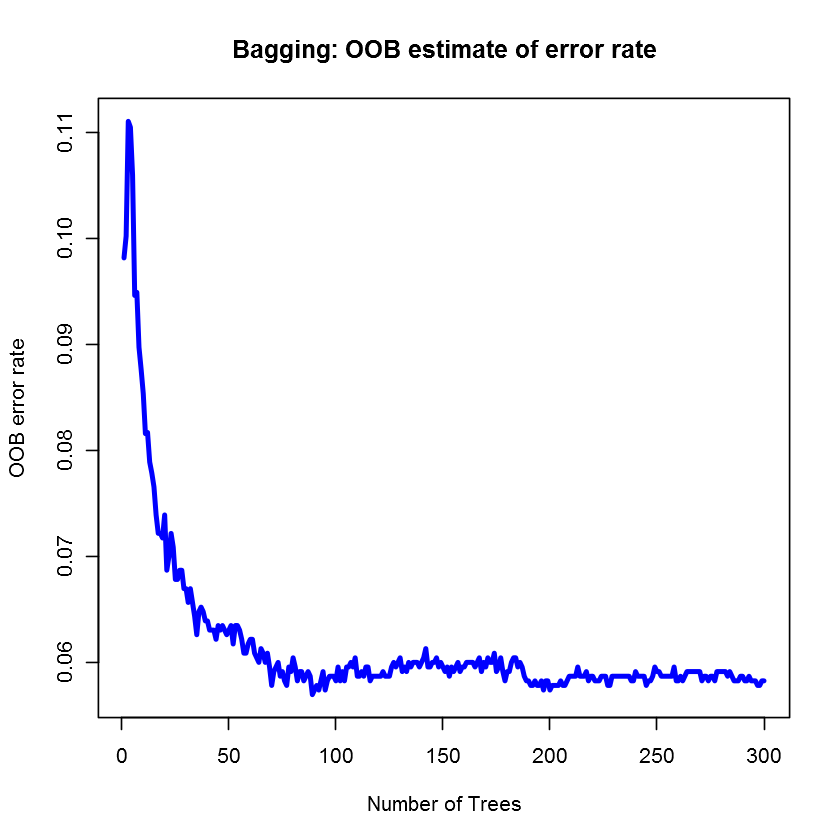

In [17]:
plot(bg.mod$err.rate[,1], type = "l", lwd = 3, col = "blue",
     main = "Bagging: OOB estimate of error rate",
     xlab = "Number of Trees", ylab = "OOB error rate")

Here, 300 trees seems more than sufficient. One advantage of bagging and random forest models is that they provide a way of doing feature or variable selection, by considering the importance of each variable in the model. For exact details on how these importance measures are defined, refer to the slides.

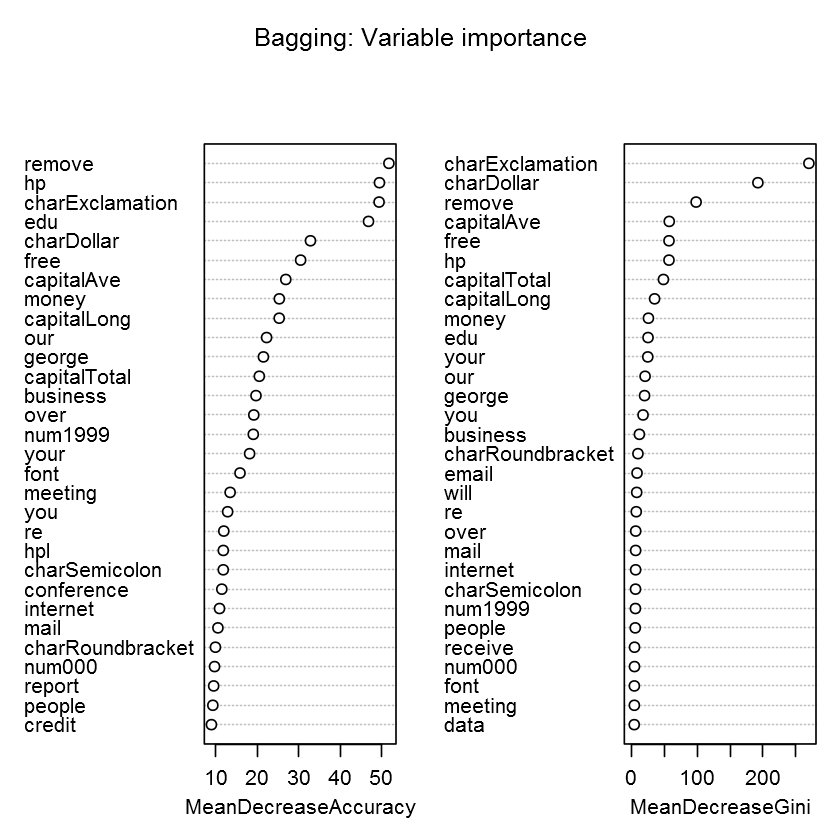

In [14]:
varImpPlot(bg.mod,
           main = "Bagging: Variable importance")

In addition, we can visualize the classification done by the model using a multidimensional plot on the proximity matrix. The green samples in the figure represent nonspams, while the red samples are spams.

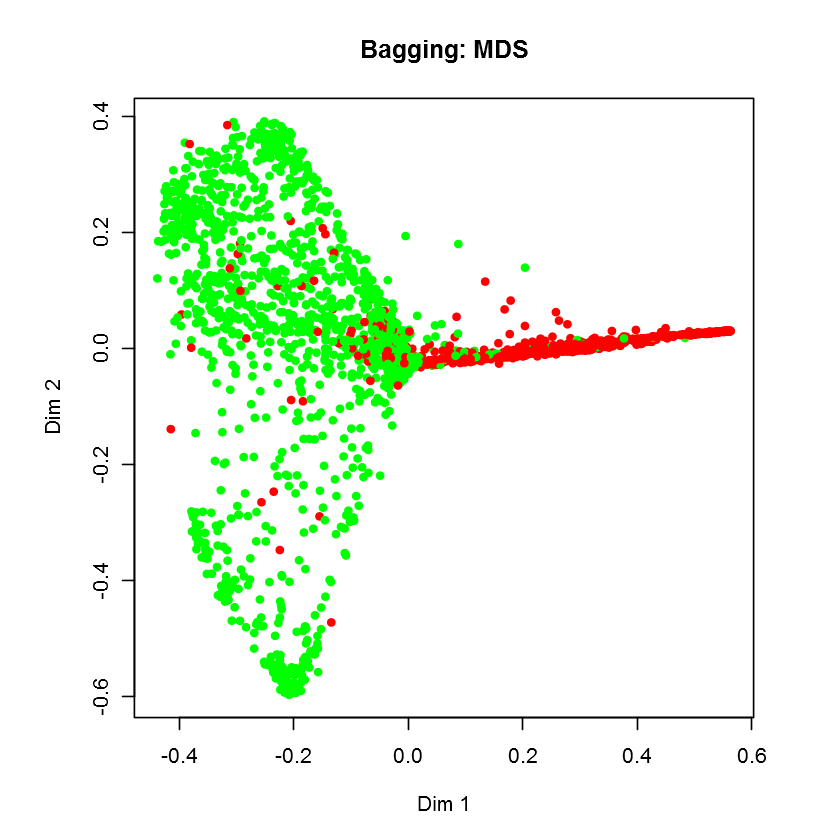

In [15]:
MDSplot(bg.mod,
        fac = spam.train$type,
        palette = c("green","red"),
        main = "Bagging: MDS")

Finally, let’s make some predictions on the testing data:

In [16]:
bg.pred <- predict(bg.mod,
                   subset(spam.test, select = -type), 
                   type = "class")

# confusion matrix
# rows are the predicted classes
# columns are the actual classes
print(bg.pred.results <- table(bg.pred, spam.test$type))

         
bg.pred   nonspam spam
  nonspam    1335   87
  spam         56  823


In [17]:
# what is the accuracy of our bagging model?
print(bg.accuracy <- sum(diag((bg.pred.results))) / sum(bg.pred.results))

[1] 0.9378531


Our bagging model predicts whether an email is spam or not with about 93.87% accuracy.

## Random Forest
The only difference between the bagging model and random forest model is that the latter uses chooses only from a subset of variables to split on at each node of each tree. In other words, only the mtry argument differs between bagging and random forest.

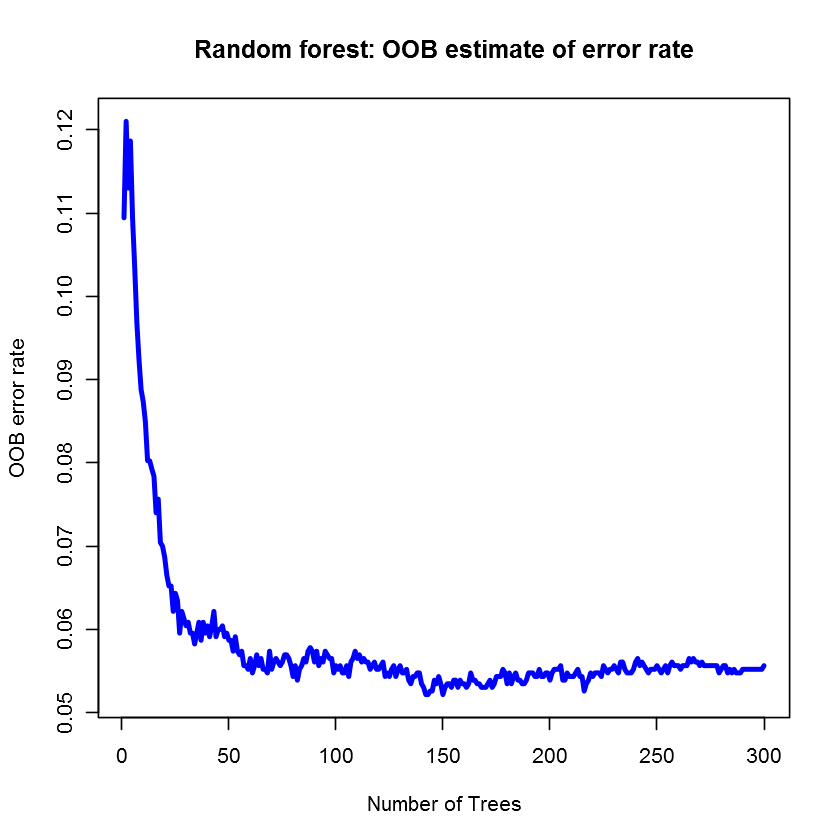

In [18]:
rf.mod <- randomForest(type ~ ., data = spam.train,
                       mtry = floor(sqrt(num.var - 1)), # 7; only difference from bagging is here
                       ntree = 300,
                       proximity = TRUE,
                       importance = TRUE)

# Out-of-bag (OOB) error rate as a function of num. of trees:
plot(rf.mod$err.rate[,1], type = "l", lwd = 3, col = "blue",
     main = "Random forest: OOB estimate of error rate",
     xlab = "Number of Trees", ylab = "OOB error rate")

Besides tuning the ntree hyperparameter, we might also be interested in tuning the mtry hyperparameter in random forest. The random forest model may be built using the mtry value that minimises the OOB error.

mtry = 7  OOB error = 5.43% 
Searching left ...
mtry = 4 	OOB error = 5.39% 
0.008 0.05 
Searching right ...
mtry = 14 	OOB error = 5.74% 
-0.056 0.05 


,mtry,OOBError
4.OOB,4.00000000,0.05391304
7.OOB,7.00000000,0.05434783
14.OOB,14.0000000,0.0573913


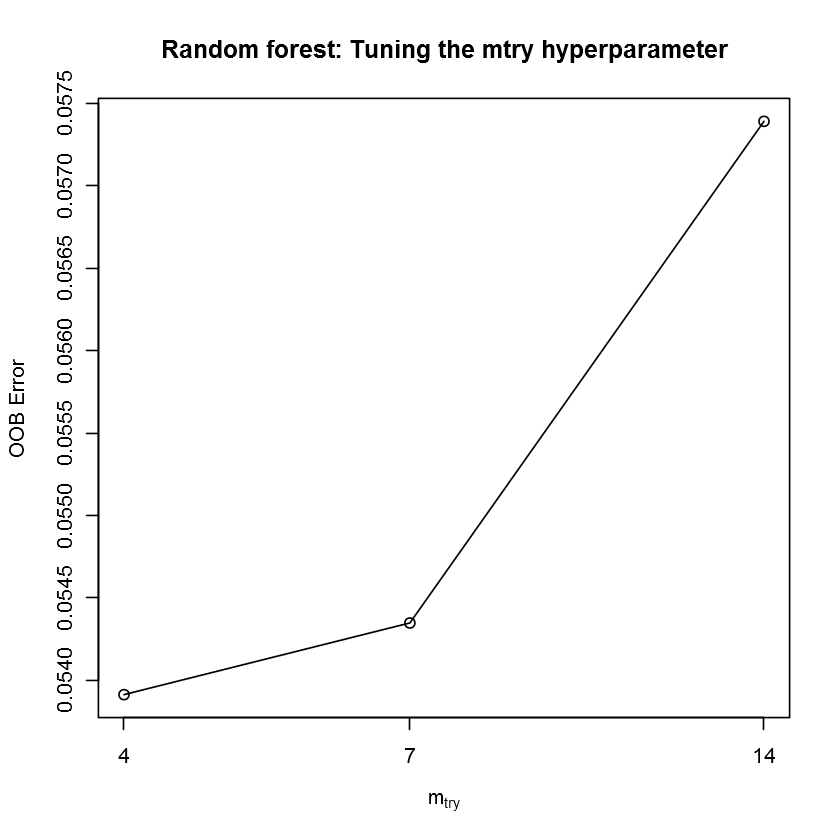

In [25]:
tuneRF(subset(spam.train, select = -type),
       spam.train$type,
       ntreeTry = 100)

title("Random forest: Tuning the mtry hyperparameter")

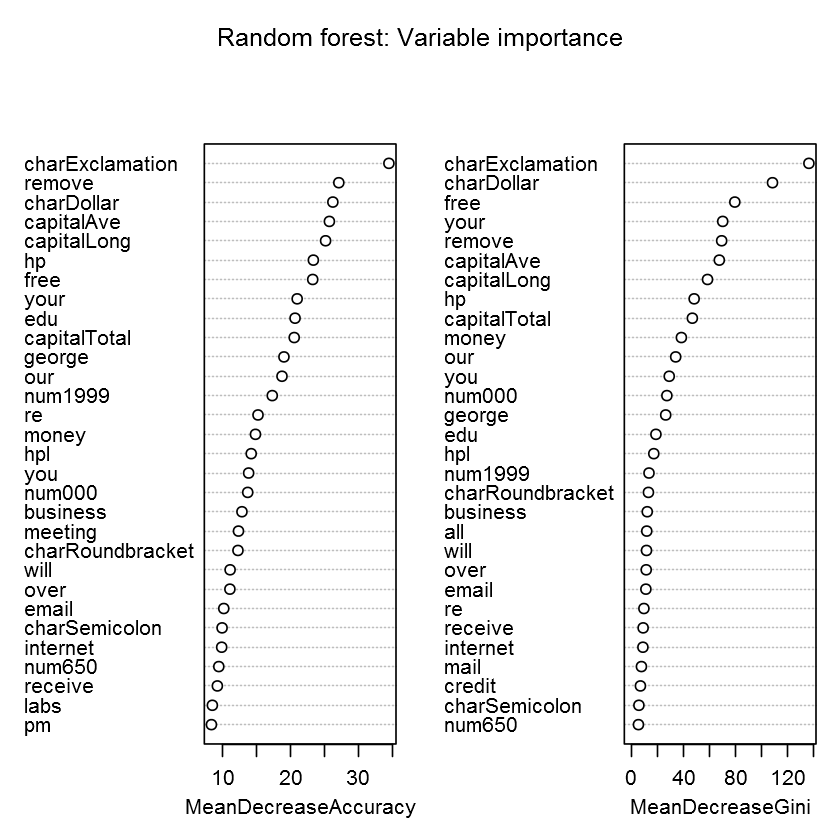

In [26]:
# variable importance
varImpPlot(rf.mod,
           main = "Random forest: Variable importance")

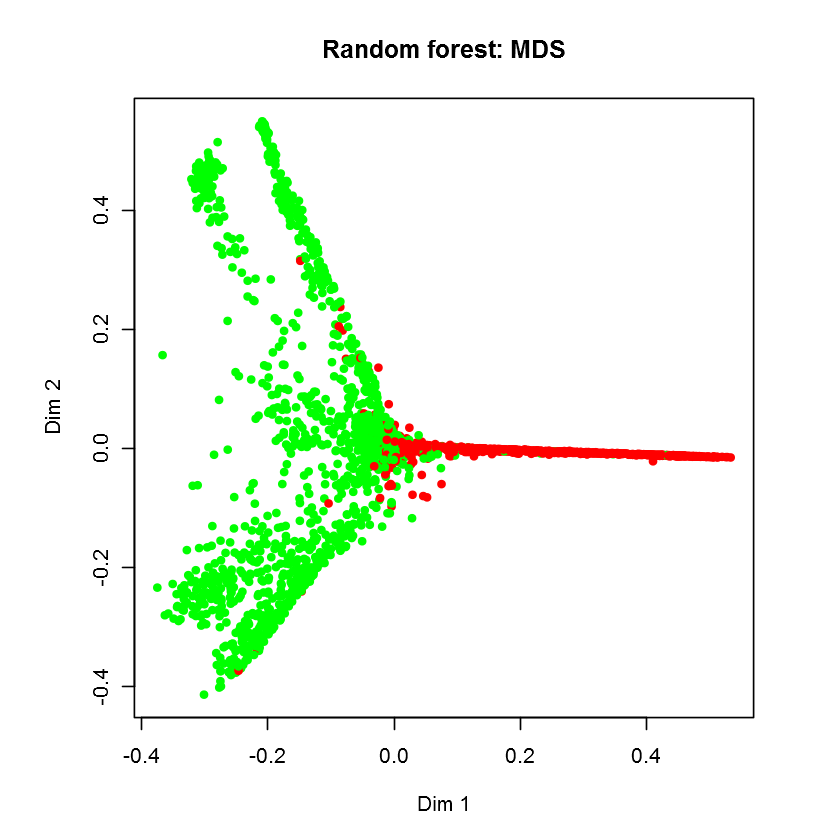

In [27]:
# multidimensional scaling plot
# green samples are non-spam,
# red samples are spam
MDSplot(rf.mod,
        fac = spam.train$type,
        palette = c("green","red"),
        main = "Random forest: MDS")

In [19]:
# now, let's make some predictions
rf.pred <- predict(rf.mod,
                   subset(spam.test,select = -type), 
                   type="class")

# confusion matrix
print(rf.pred.results <- table(rf.pred, spam.test$type))

         
rf.pred   nonspam spam
  nonspam    1351   81
  spam         40  829


In [20]:
# Accuracy of our RF model:
print(rf.accuracy <- sum(diag((rf.pred.results))) / sum(rf.pred.results))

[1] 0.9474142


Our random forest model predicts whether an email is spam or not with about 94.7% accuracy.

## Visualization of performances
Let’s go ahead and make some comparisons on the performances of our model. For comparison sake, let’s also construct a logistic regression model.

In [21]:
log.mod <- glm(type ~ . , data = spam.train,
             family = binomial(link = logit))

Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

In [22]:
# predictions
log.pred.prob <- predict(log.mod,
                         subset(spam.test, select = -type), 
                         type = "response")
log.pred.class <- factor(sapply(log.pred.prob,
                                FUN = function(x){
                                        if(x >= 0.5) return("spam")
                                        else return("nonspam")
                                }))

# confusion matrix
log.pred.results <- table(log.pred.class, spam.test$type)

# Accuracy of logistic regression model:
print(log.accuracy <- sum(diag((log.pred.results))) / sum(log.pred.results))

[1] 0.9135159


Now, let’s compare the performances, considering first the model accuracies.

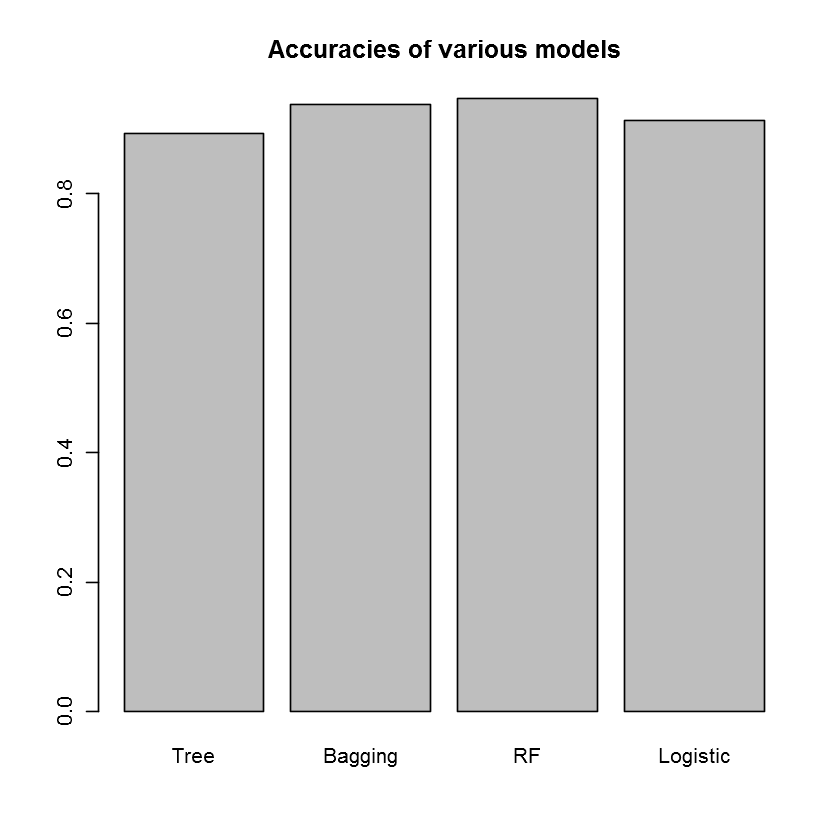

In [23]:
barplot(c(tree.accuracy,
          bg.accuracy,
          rf.accuracy,
          log.accuracy),
        main="Accuracies of various models",
        names.arg=c("Tree","Bagging","RF", "Logistic"))

We can see here that the ensemble models (bagging and random forest) outperforms the single decision tree, and also the logistic regression model. It turns out here that the bagging and the random forest models have about the same classification performance. Understanding the rationale of random subspace sampling (refer to slides) should allow us to appreciate the potential improvement of random forest over the bagging model.

Finally, let’s plot the ROC curves of the various models. The ROC is only valid for models that give probabilistic output.


Call:
plot.roc.default(x = spam.test$type, predictor = bg.pred.prob[,     1], col = "blue", lwd = 3, print.auc = TRUE, print.auc.y = 0.3,     main = "ROC-AUC of various models")

Data: bg.pred.prob[, 1] in 1391 controls (spam.test$type nonspam) > 910 cases (spam.test$type spam).
Area under the curve: 0.9741


Call:
plot.roc.default(x = spam.test$type, predictor = rf.pred.prob[,     1], col = "green", lwd = 3, print.auc = TRUE, print.auc.y = 0.2,     add = TRUE)

Data: rf.pred.prob[, 1] in 1391 controls (spam.test$type nonspam) > 910 cases (spam.test$type spam).
Area under the curve: 0.9818


Call:
plot.roc.default(x = spam.test$type, predictor = log.pred.prob,     col = "red", lwd = 3, print.auc = TRUE, print.auc.y = 0.1,     add = TRUE)

Data: log.pred.prob in 1391 controls (spam.test$type nonspam) < 910 cases (spam.test$type spam).
Area under the curve: 0.9703

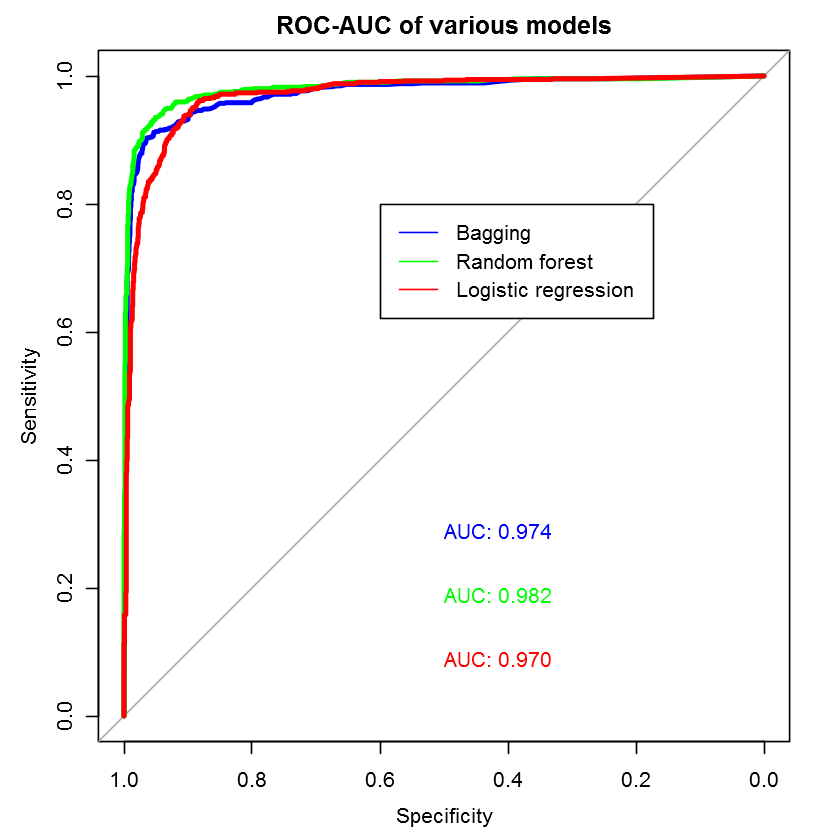

In [35]:
bg.pred.prob <- predict(bg.mod ,
                        subset(spam.test, select = -type),
                        type = "prob")

rf.pred.prob <- predict(rf.mod ,
                        subset(spam.test, select = -type),
                        type = "prob")

plot.roc(spam.test$type,
         bg.pred.prob[,1], col = "blue",
         lwd = 3, print.auc = TRUE, print.auc.y = 0.3,
         main = "ROC-AUC of various models")

plot.roc(spam.test$type,
         rf.pred.prob[,1], col = "green",
         lwd = 3, print.auc = TRUE, print.auc.y = 0.2,
         add = TRUE)

plot.roc(spam.test$type,
         log.pred.prob, col = "red",
         lwd = 3, print.auc = TRUE, print.auc.y = 0.1,
         add = TRUE)

legend(x = 0.6, y = 0.8, legend = c("Bagging",
                                    "Random forest",
                                    "Logistic regression"),
       col = c("blue", "green", "red"), lwd = 1)

Refer to 02-Regression (automobile prices) for using random forest for regression.